FEM CODE for Heat Conduction -- First Author chatGPT

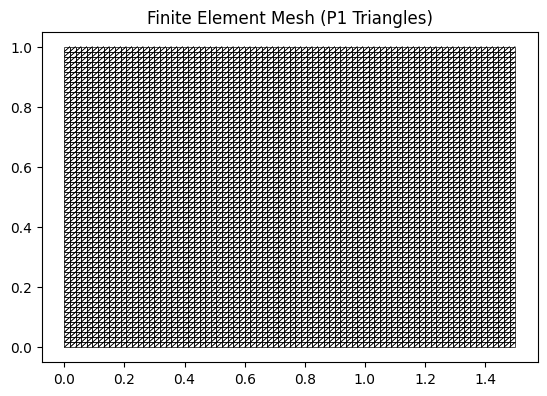

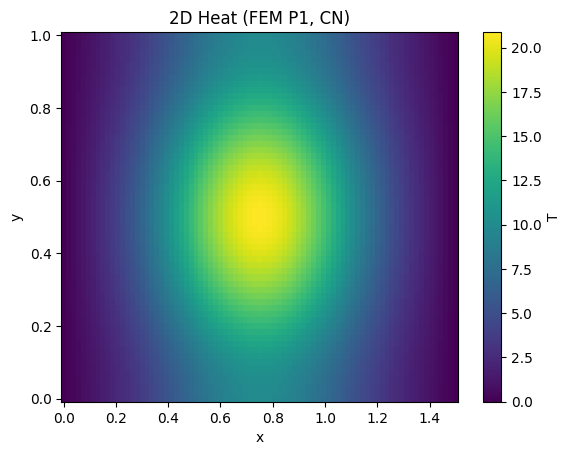

In [2]:
# fem2d_heat.py
# pip install numpy scipy matplotlib

import numpy as np
from scipy.sparse import lil_matrix, csr_matrix, diags
from scipy.sparse.linalg import spsolve

def build_rect_tri_mesh(NX=40, NY=40, Lx=1.0, Ly=1.0):
    """Uniform grid nodes and 2*NX*NY triangles (right-leaning split)."""
    x = np.linspace(0.0, Lx, NX+1)
    y = np.linspace(0.0, Ly, NY+1)
    X, Y = np.meshgrid(x, y)               # shape (NY+1, NX+1)
    coords = np.column_stack([X.ravel(), Y.ravel()])
    def idx(i,j): return j*(NX+1) + i

    tris = []
    for j in range(NY):
        for i in range(NX):
            n0 = idx(i,   j)
            n1 = idx(i+1, j)
            n2 = idx(i,   j+1)
            n3 = idx(i+1, j+1)
            # triangles: (n0,n1,n3) and (n0,n3,n2)
            tris.append([n0,n1,n3])
            tris.append([n0,n3,n2])
    tris = np.asarray(tris, dtype=np.int32)
    return coords, tris, (x, y)

def assemble_K_M(coords, tris, k=1.0, rho=1.0, cp=1.0):
    """Assemble global stiffness K and consistent mass M for P1 triangles."""
    N = coords.shape[0]
    K = lil_matrix((N, N), dtype=float)
    M = lil_matrix((N, N), dtype=float)
    rc = rho*cp

    for (n1, n2, n3) in tris:
        x1,y1 = coords[n1]; x2,y2 = coords[n2]; x3,y3 = coords[n3]
        detJ = (x2-x1)*(y3-y1) - (x3-x1)*(y2-y1)
        A = 0.5*abs(detJ)
        if A <= 1e-18: 
            continue

        # Gradients of shape functions via b,c coefficients
        b = np.array([y2 - y3, y3 - y1, y1 - y2])
        c = np.array([x3 - x2, x1 - x3, x2 - x1])

        Ke = (k/(4.0*A))*(np.outer(b,b) + np.outer(c,c))
        Me = (rc*A/12.0)*np.array([[2,1,1],[1,2,1],[1,1,2]])

        nodes = [n1,n2,n3]
        for a in range(3):
            ia = nodes[a]
            for b_ in range(3):
                ib = nodes[b_]
                K[ia, ib] += Ke[a, b_]
                M[ia, ib] += Me[a, b_]

    return K.tocsr(), M.tocsr()

def assemble_F(coords, tris, q_func, t):
    """Load vector F from volumetric source q(x,y,t), 1-point (centroid) rule."""
    N = coords.shape[0]
    F = np.zeros(N)
    for (n1, n2, n3) in tris:
        x1,y1 = coords[n1]; x2,y2 = coords[n2]; x3,y3 = coords[n3]
        detJ = (x2-x1)*(y3-y1) - (x3-x1)*(y2-y1)
        A = 0.5*abs(detJ)
        xc = (x1+x2+x3)/3.0; yc=(y1+y2+y3)/3.0
        q = q_func(xc, yc, t)
        fe = (q*A/3.0)  # each node gets q*A/3 for uniform q over the element
        F[n1] += fe; F[n2] += fe; F[n3] += fe
    return F

def impose_dirichlet(A, b, fixed_nodes, fixed_values):
    """
    Enforce Dirichlet by row replacement (A[i,:]=e_i^T, b[i]=Tbc).
    For symmetry, you'd also zero columns and adjust b, but row fix works well in practice.
    """
    A = A.tolil()
    for i, val in zip(fixed_nodes, fixed_values):
        A.rows[i] = [i]
        A.data[i] = [1.0]
        b[i] = val
    return A.tocsr(), b

def plot_mesh(coords, tris, show=True):
    import matplotlib.pyplot as plt
    from matplotlib.collections import LineCollection

    # Extract line segments from triangle connectivity
    segments = []
    for tri in tris:
        for i in range(3):
            a = coords[tri[i]]
            b = coords[tri[(i+1)%3]]
            segments.append([a, b])

    lc = LineCollection(segments, colors="k", linewidths=0.5)
    fig, ax = plt.subplots()
    ax.add_collection(lc)
    ax.autoscale()
    ax.set_aspect("equal")
    ax.set_title("Finite Element Mesh (P1 Triangles)")
    if show:
        plt.show()
    return fig, ax

##################################################
# what it does:
# it builds the mesh (2d plate)
# assembles the FEM matrices (stiffness and mass)
# runs the time-stepping solver (Crank-Nicolson or Backward Euler)
# gives the temperature field at the final time and (optimally) all time snapshots
##################################################
def heat2d_fem(
    NX=60, NY=60, Lx=1.0, Ly=1.0,
    k=1.0, rho=1.0, cp=1.0,
    T_left=0.0, T_right=0.0,
    q_func=lambda x,y,t: 0.0,           # source q(x,y,t)
    dt=1e-3, t_end=0.25,
    scheme="CN",                        # "BE" (Backward Euler) or "CN" (Crank–Nicolson)
    return_history=False, output_every=None,
    plotmesh=False
):
    """
    Returns (x, y, T_final, history)
      - x, y: 1D coordinate arrays (nodes)
      - T_final: (NY+1, NX+1) array at t_end
      - history: list of (t, T_snapshot) if requested
    """
    coords, tris, (x, y) = build_rect_tri_mesh(NX, NY, Lx, Ly)
    if plotmesh == True:
        plot_mesh(coords, tris, show=True)
    N = coords.shape[0]
    npx = NX+1

    # Assemble time-invariant K, M
    K, M = assemble_K_M(coords, tris, k=k, rho=rho, cp=cp)

    # Initial condition: linear between left and right
    T = np.zeros(N)
    T[:] = T_left + (T_right - T_left)*(coords[:,0]/Lx)

    # Dirichlet on left/right boundary node sets
    left_nodes  = np.where(np.isclose(coords[:,0], 0.0))[0]
    right_nodes = np.where(np.isclose(coords[:,0], Lx))[0]
    fixed_nodes = np.concatenate([left_nodes, right_nodes])
    fixed_vals  = np.concatenate([np.full_like(left_nodes,  T_left,  dtype=float),
                                  np.full_like(right_nodes, T_right, dtype=float)])

    # Time-stepping matrices (scheme-dependent, but K and M are constant)
    nsteps = int(np.ceil(t_end/dt))
    history = []

    t = 0.0
    for step in range(1, nsteps+1):
        t_np1 = t + dt

        if scheme.upper() == "CN":
            # Crank–Nicolson: A = M/dt + 0.5K; rhs = (M/dt - 0.5K) T^n + 0.5(F^{n+1}+F^n)
            A = (M/dt + 0.5*K).tocsr()
            F_n   = assemble_F(coords, tris, q_func, t)
            F_np1 = assemble_F(coords, tris, q_func, t_np1)
            rhs = (M/dt - 0.5*K) @ T + 0.5*(F_n + F_np1)
        else:
            # Backward Euler: A = M/dt + K; rhs = (M/dt) T^n + F^{n+1}
            A = (M/dt + K).tocsr()
            F_np1 = assemble_F(coords, tris, q_func, t_np1)
            rhs = (M/dt) @ T + F_np1

        # Impose Dirichlet
        A, rhs = impose_dirichlet(A, rhs, fixed_nodes, fixed_vals)

        # Solve
        T = spsolve(A, rhs)

        # Save snapshots
        if return_history and (output_every is None or step % output_every == 0 or step == nsteps):
            history.append((t_np1, T.reshape(NY+1, NX+1).copy()))

        t = t_np1

    return x, y, T.reshape(NY+1, NX+1), history if return_history else None


if __name__ == "__main__":
    # Example: smooth transient with a decaying Gaussian source near x=0.75,y=0.5; note exponential decay of source wrt time
    def q(x, y, t):
        return 100.0*np.exp(-10*(x-0.75)**2 - 10*(y-0.5)**2) * np.exp(-1*t)

    x, y, T, _ = heat2d_fem(
        NX=80, NY=60, Lx=1.5, Ly=1.0,
        k=0.10, rho=1.0, cp=1.0,
        T_left=0.0, T_right=0.0,
        q_func=q,
        dt=5e-3, t_end=0.5,
        scheme="CN",                    # try "BE" or "CN"
        return_history=False,
        plotmesh=True
    )

    # Quick plot
    try:
        import matplotlib.pyplot as plt
        X, Y = np.meshgrid(x, y)
        plt.figure()
        pc = plt.pcolormesh(X, Y, T, shading="auto")
        plt.colorbar(pc, label="T")
        plt.xlabel("x"); plt.ylabel("y"); plt.title("2D Heat (FEM P1, CN)")
        plt.show()
    except Exception as e:
        print("Plotting skipped:", e)

If parameters k=0.1,1.0,10.0, t<sub>f</sub> =0.1,0.2,0.5 plot the temperature field T(x,y,t<sub>f</sub>). 
Please sample T(x,y,t) at 10 randomly chosen points and plot T(t) at each site.

k:  0.1  | tf:  0.1
k:  0.1  | tf:  0.2
k:  0.1  | tf:  0.5
k:  1.0  | tf:  0.1
k:  1.0  | tf:  0.2
k:  1.0  | tf:  0.5
k:  10.0  | tf:  0.1
k:  10.0  | tf:  0.2
k:  10.0  | tf:  0.5


Text(0.5, 0.98, 'Temperature for ks and tfs')

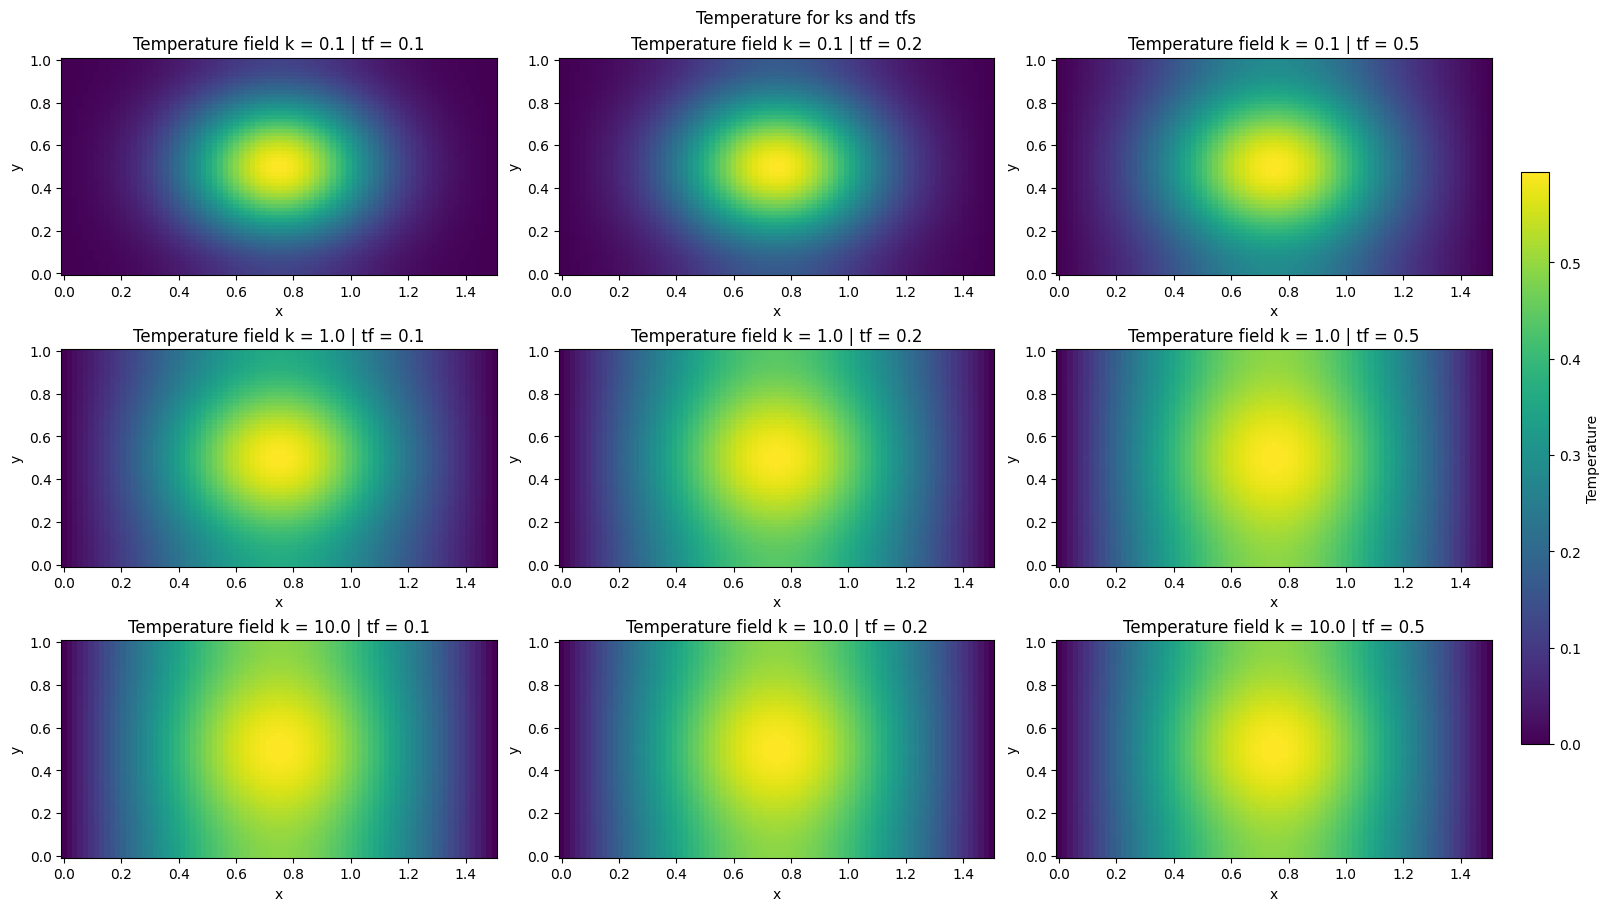

In [8]:
ks = [0.1, 1.0, 10.0]
tfs = [0.1, 0.2, 0.5]
result_dict = {}

fig, axes = plt.subplots(len(ks), len(tfs), figsize=(16, 9), constrained_layout=True)

for ik, k in enumerate(ks):
    for itf, tf in enumerate(tfs):
        print("k: ", k, " | tf: ", tf)
        x, y, T_final, history = heat2d_fem(NX=80, NY=60, Lx=1.5, Ly=1.0,
                                            k=k, q_func=q, dt=5e-3, t_end=tf,
                                            return_history=True, output_every=10)
        result_dict[(k, tf)] = [x, y, T_final, history]
        
        # Quick plot
        ax = axes[ik, itf]
        X, Y = np.meshgrid(x, y)
        pc = ax.pcolormesh(X, Y, T_final, shading="auto")
        ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_title(f"Temperature field k = {k} | tf = {tf}")

cbar = fig.colorbar(pc, ax=axes, orientation='vertical', fraction=.02, pad=.02)
cbar.set_label("Temperature")
plt.suptitle("Temperature for ks and tfs")


The yellow gets bigger why?
Because K which is effected by k governs how heat spreads between nodes. So a larger k means faster heat transfer.

It gets bigger when you go across the rows because tf (final time) is getting bigger which means the heat can spread out more since it is a longer period of time.